# Segmentation of active regions with Convolution Neural Network

In [1]:
import sys, os
sys.path.append('../src')

In [3]:
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import albumentations

from model_unet import unet
from metrics import dice_np, iou_np, dice, iou
from utils import plot_imgs, plot_metrics

from ImageDataAugmentor.image_data_augmentor import *

In [4]:
# Create lists with path to each file
imgs = glob.glob("../data/171/171(zooniverse)_1024/imgs/*.png")
masks = glob.glob("../data/171/171(zooniverse)_1024/masks/*.png")

print(f"Imgs number = {len(imgs)}\nMasks number = {len(masks)}")

Imgs number = 2132
Masks number = 2132


In [5]:
# Load data and convert imgs to np.array
IMG_SIZE = 256  # resize imgs to 256x256
imgs_list = []
masks_list = []
for image, mask in zip(imgs, masks):
    imgs_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
    masks_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))

In [6]:
# Normalization from (0; 255) to (0; 1)
x = np.asarray(imgs_list, dtype=np.float32)/255
y = np.asarray(masks_list, dtype=np.float32)/255

# Reshape to (n_imgs, height, width, channels)
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)

# Split data to Train set (90%) and Validation set (10%)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=None, shuffle=True)

In [7]:
# Define which image augmentations we want to use
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=.5),
    albumentations.VerticalFlip(p=.5),
    albumentations.Rotate((-45, 45), p=.5, border_mode=cv2.BORDER_REPLICATE),
    # Make imgs little brigther
    albumentations.RandomGamma((100, 150), p=.5),
    albumentations.RandomBrightnessContrast((.0, .2), (.0, .4), p=.5)
])

# Set batch size
BATCH_SIZE = 20

# Generator for images
img_data_gen = ImageDataAugmentor(augment=AUGMENTATIONS, augment_seed=42)
img_gen = img_data_gen.flow(x_train, batch_size=BATCH_SIZE, shuffle=True, seed=42)

# Generator for masks
mask_data_gen = ImageDataAugmentor(augment=AUGMENTATIONS, augment_seed=42, augment_mode='mask')
mask_gen = mask_data_gen.flow(y_train, batch_size=BATCH_SIZE, shuffle=True, seed=42)

# Train set with augmented data
train_gen = zip(img_gen, mask_gen)

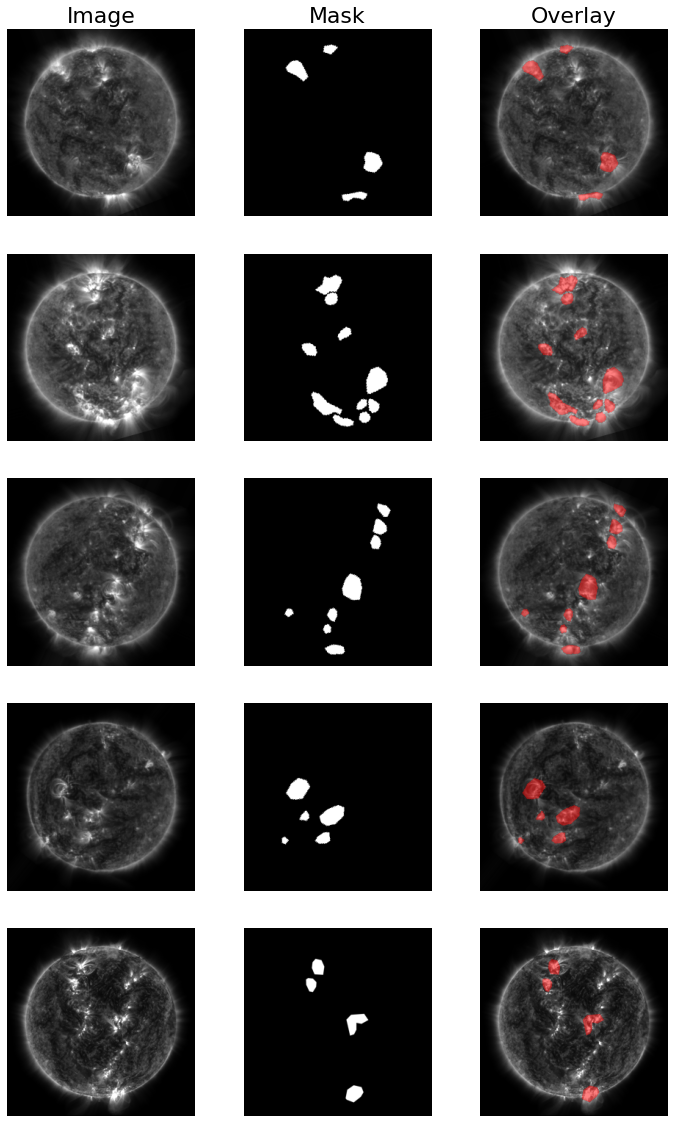

In [8]:
# Plot augmented imgs sample
x_sample, y_sample = next(train_gen)
plot_imgs(imgs=x_sample, masks=y_sample, n_imgs=5).show()

In [9]:
# Check if input shape is correct
input_shape = x_train[0].shape
print(f"Input shape: {input_shape}\nTrain shape: {x_train.shape}  Val shape: {x_val.shape}")

Input shape: (256, 256, 1)
Train shape: (1918, 256, 256, 1)  Val shape: (214, 256, 256, 1)


In [10]:
MODEL_NAME = "unet_ar_segmentation"  # Specify model name
model_filename = f"../results/models/{MODEL_NAME}.h5"  # Specify path where to save model

# Create model with specific parameteres
model = unet(
    input_shape,
    filters=32,  # Doubles within each layer
    layers=4,
    batch_norm=True,
    drop_prob=0.5)

# Callback that saves only best weights
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor="val_loss",
    save_best_only=True)

# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  # Loss function for binary classification
    metrics=[iou, dice]  # Metrics that we monitor during training
)

In [11]:
# Save model as json
model_json = model.to_json()
model_json_filename = model_filename.replace("h5", "json")
with open(model_json_filename, "w") as json_file:
    json_file.write(model_json)

In [12]:
EPOCHS = 100  # Set number of epochs
STEPS = x_train.shape[0] // BATCH_SIZE  # Set steps parameters acording to size of training set and size of batch

# Train model
history = model.fit(
    train_gen,
    steps_per_epoch=STEPS,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint],
    verbose=2
)


Epoch 00001: val_loss improved from inf to 0.29041, saving model to ../results/models\unet_ar_segmentation.h5
95/95 - 77s - loss: 0.2161 - iou: 0.1070 - dice: 0.1918 - val_loss: 0.2904 - val_iou: 0.0313 - val_dice: 0.0607

Epoch 00003: val_loss improved from 0.29041 to 0.10019, saving model to ../results/models\unet_ar_segmentation.h5
95/95 - 68s - loss: 0.0632 - iou: 0.2915 - dice: 0.4504 - val_loss: 0.1002 - val_iou: 0.0623 - val_dice: 0.1173

Epoch 00004: val_loss improved from 0.10019 to 0.09982, saving model to ../results/models\unet_ar_segmentation.h5
95/95 - 68s - loss: 0.0509 - iou: 0.3548 - dice: 0.5234 - val_loss: 0.0998 - val_iou: 0.0596 - val_dice: 0.1125

Epoch 00005: val_loss improved from 0.09982 to 0.09151, saving model to ../results/models\unet_ar_segmentation.h5
95/95 - 68s - loss: 0.0447 - iou: 0.3955 - dice: 0.5665 - val_loss: 0.0915 - val_iou: 0.0994 - val_dice: 0.1808

Epoch 00007: val_loss improved from 0.09151 to 0.04783, saving model to ../results/models\unet_a

In [13]:
model.load_weights(model_filename)  # To use best model not latest model we need to load weights from .h5 file
y_pred = model.predict(x_val)  # Predict new masks for validation set

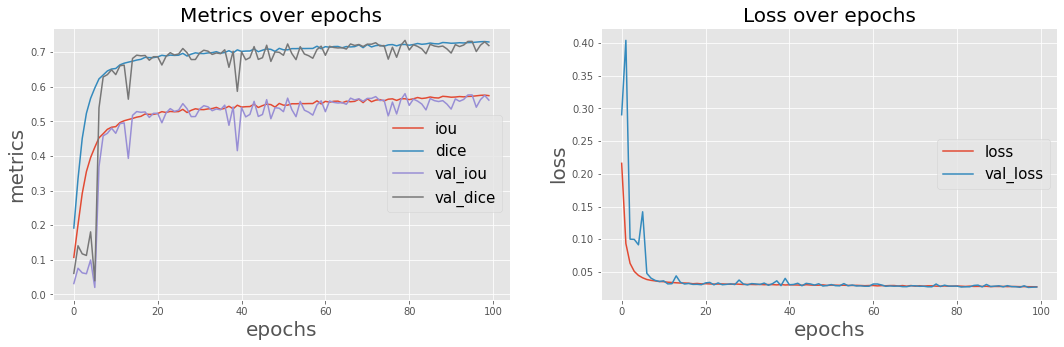

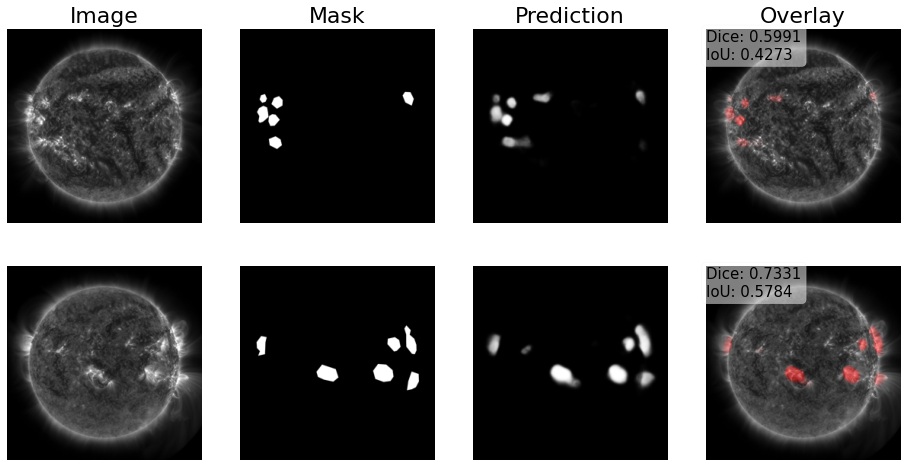

In [14]:
# Plot training history and predicted imgs
plot_metrics(history).show()
plot_imgs(imgs=x_val, masks=y_val, predictions=y_pred, n_imgs=2).show()

In [15]:
# Results
y_pred_bin = np.where(y_pred > 0.5, 1, 0)  # Threshold predicted values

dice = np.round(dice_np(y_val, y_pred), 4)
iou_val = np.round(iou_np(y_val, y_pred), 4)

dice_tresh = np.round(dice_np(y_val, y_pred_bin), 4)
iou_val_tresh = np.round(iou_np(y_val, y_pred_bin), 4)

print(f"Validation:\nDice: {dice} Dice_tresh: {dice_tresh}\n IoU: {iou_val} IoU_tresh: {iou_val_tresh}\n")

Validation:
Dice: 0.7212 Dice_tresh: 0.8025
 IoU: 0.564 IoU_tresh: 0.6702



## Test set

In [16]:
# Create lists with path to each file
imgs_test = glob.glob("../data/171/171(2016)_1024/imgs/*.png")
masks_test = glob.glob("../data/171/171(2016)_1024/masks/*.png")

print(f"Imgs number = {len(imgs_test)}\nMasks number = {len(masks_test)}")

Imgs number = 360
Masks number = 360


In [17]:

# Load data and convert imgs to np.array
IMG_SIZE = 256  # resize imgs to 256x256
imgs_list = []
masks_list = []
for image, mask in zip(imgs_test, masks_test):
    imgs_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
    masks_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))

# Normalization from (0; 255) to (0; 1)
x_test = np.asarray(imgs_list, dtype=np.float32)/255
y_test = np.asarray(masks_list, dtype=np.float32)/255

# Reshape to (n_imgs, height, width, channels)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1)

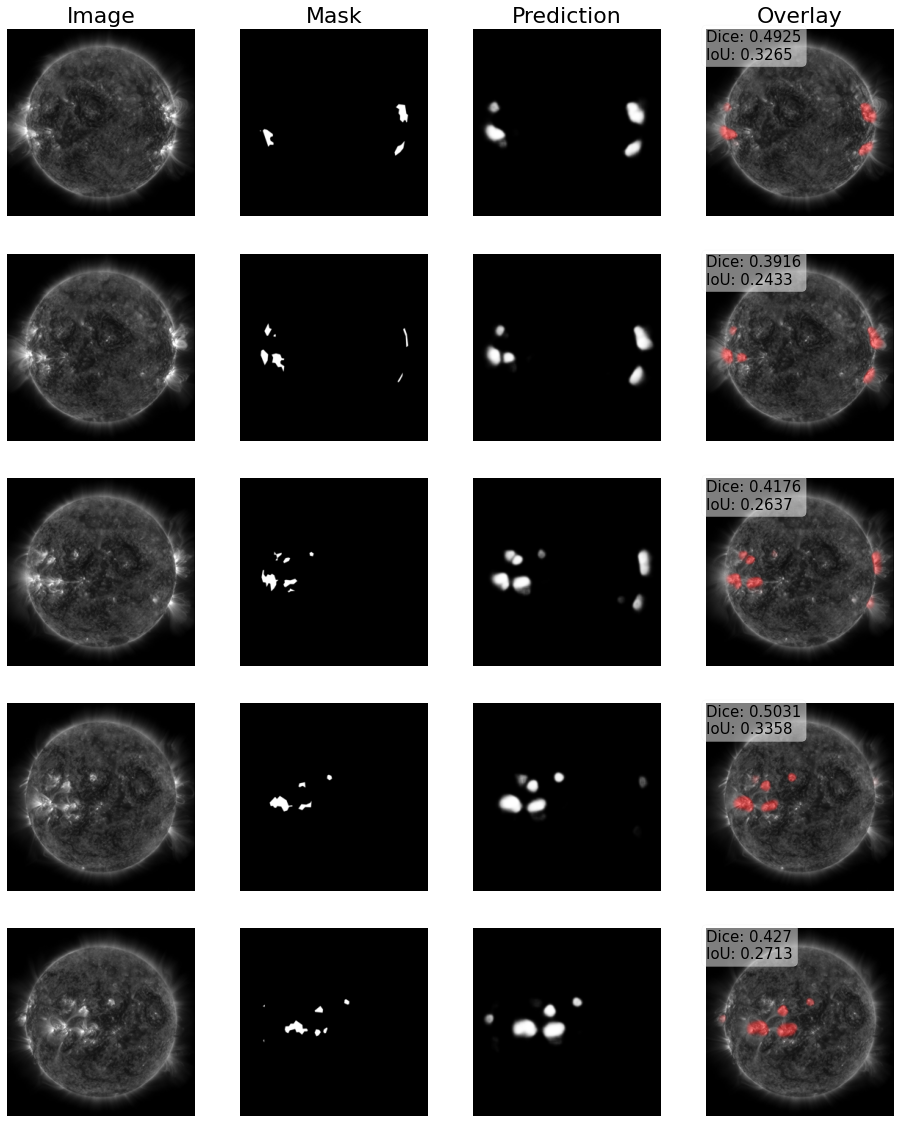

In [18]:
y_pred = model.predict(x_test)  # Predict new masks for validation set
plot_imgs(imgs=x_test, masks=y_test, predictions=y_pred, n_imgs=5).show()

In [19]:
# Results
y_pred_bin = np.where(y_pred > 0.5, 1, 0)  # Binarize predicted values

dice = np.round(dice_np(y_test, y_pred), 4)
iou_test = np.round(iou_np(y_test, y_pred), 4)

dice_tresh = np.round(dice_np(y_test, y_pred_bin), 4)
iou_test_tresh = np.round(iou_np(y_test, y_pred_bin), 4)

print(f"Test:\nDice: {dice} Dice_tresh: {dice_tresh}\n IoU: {iou_test} IoU_tresh: {iou_test_tresh}\n")

Test:
Dice: 0.401 Dice_tresh: 0.4488
 IoU: 0.2507 IoU_tresh: 0.2893

